# Setup

In [68]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan

In [67]:
plt.style.use("ggplot")

In [201]:
def _validate_dates(dates):
    previous_date = dates[0]
    for date in dates[1:]:
        timedelta = (date - previous_date)
        assert timedelta.days == 1, str(timedelta)
        previous_date = date

def read_data_dict():
    filepath = "Casos_Diarios_Estado_Nacional_Confirmados_20200808.csv"
    df = pd.read_csv(filepath, index_col="nombre").drop("Nacional")
    y = df.filter(regex=("\d{2}-\d{2}-\d{4}")).transpose().astype(int)
    # Drop the last week of data as it is clearly incomplete
    y = y.iloc[:-7]
    training_dates = pd.to_datetime(y.index, format="%d-%m-%Y") 
    _validate_dates(training_dates)
    poblacion = df.poblacion
    is_observed = (y != 0).astype(int)
    data = {
        "T": len(y),
        "N": y.shape[1],
        "y": y.values,
        "is_observed": is_observed.values,
        "pop": poblacion.astype(int).values,
        "sim_T": 250, # Number of days to forecast
    }
    
    coordinates = {
        "state": list(y.columns),
        "date": training_dates,
        "forecast_date": pd.date_range(start=training_dates.min(), periods=len(training_dates) + 250)
    }
    
    return data, coordinates


def tsplot(x, y, n=20, percentile_min=2.5, percentile_max=97.5, color='gray', plot_mean=False, plot_median=False, line_color='k', ax=None, **kwargs):
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.percentile(y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(y, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    
    if ax is None:
        ax = plt.gca()
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        ax.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)


    if plot_mean:
        ax.plot(x, np.mean(y, axis=0), color=line_color)

    if plot_median:
        ax.plot(x, np.median(y, axis=0), color=line_color)
    
    return ax

In [105]:
model = pystan.StanModel(file="covid_mx.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37d3bfeea8ea281c561477c1fda47920 NOW.


In [109]:
debug = False
parameters = {
    "iter": 10 if debug else 500,
    "init": 0,
    "refresh": 10,
}

# Run

In [98]:
data, coords = read_data_dict()

In [110]:
samples = model.sampling(data, **parameters)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [196]:
# samples

# Plot

In [113]:
order = np.argsort(np.max(data['y'], axis=0))[::-1]
sorted_states = [coords["state"][i] for i in order]
first_day_of_the_month = [d for d in coords["forecast_date"] if d.day == 1]
labels = [d.strftime("%b") for d in first_day_of_the_month]

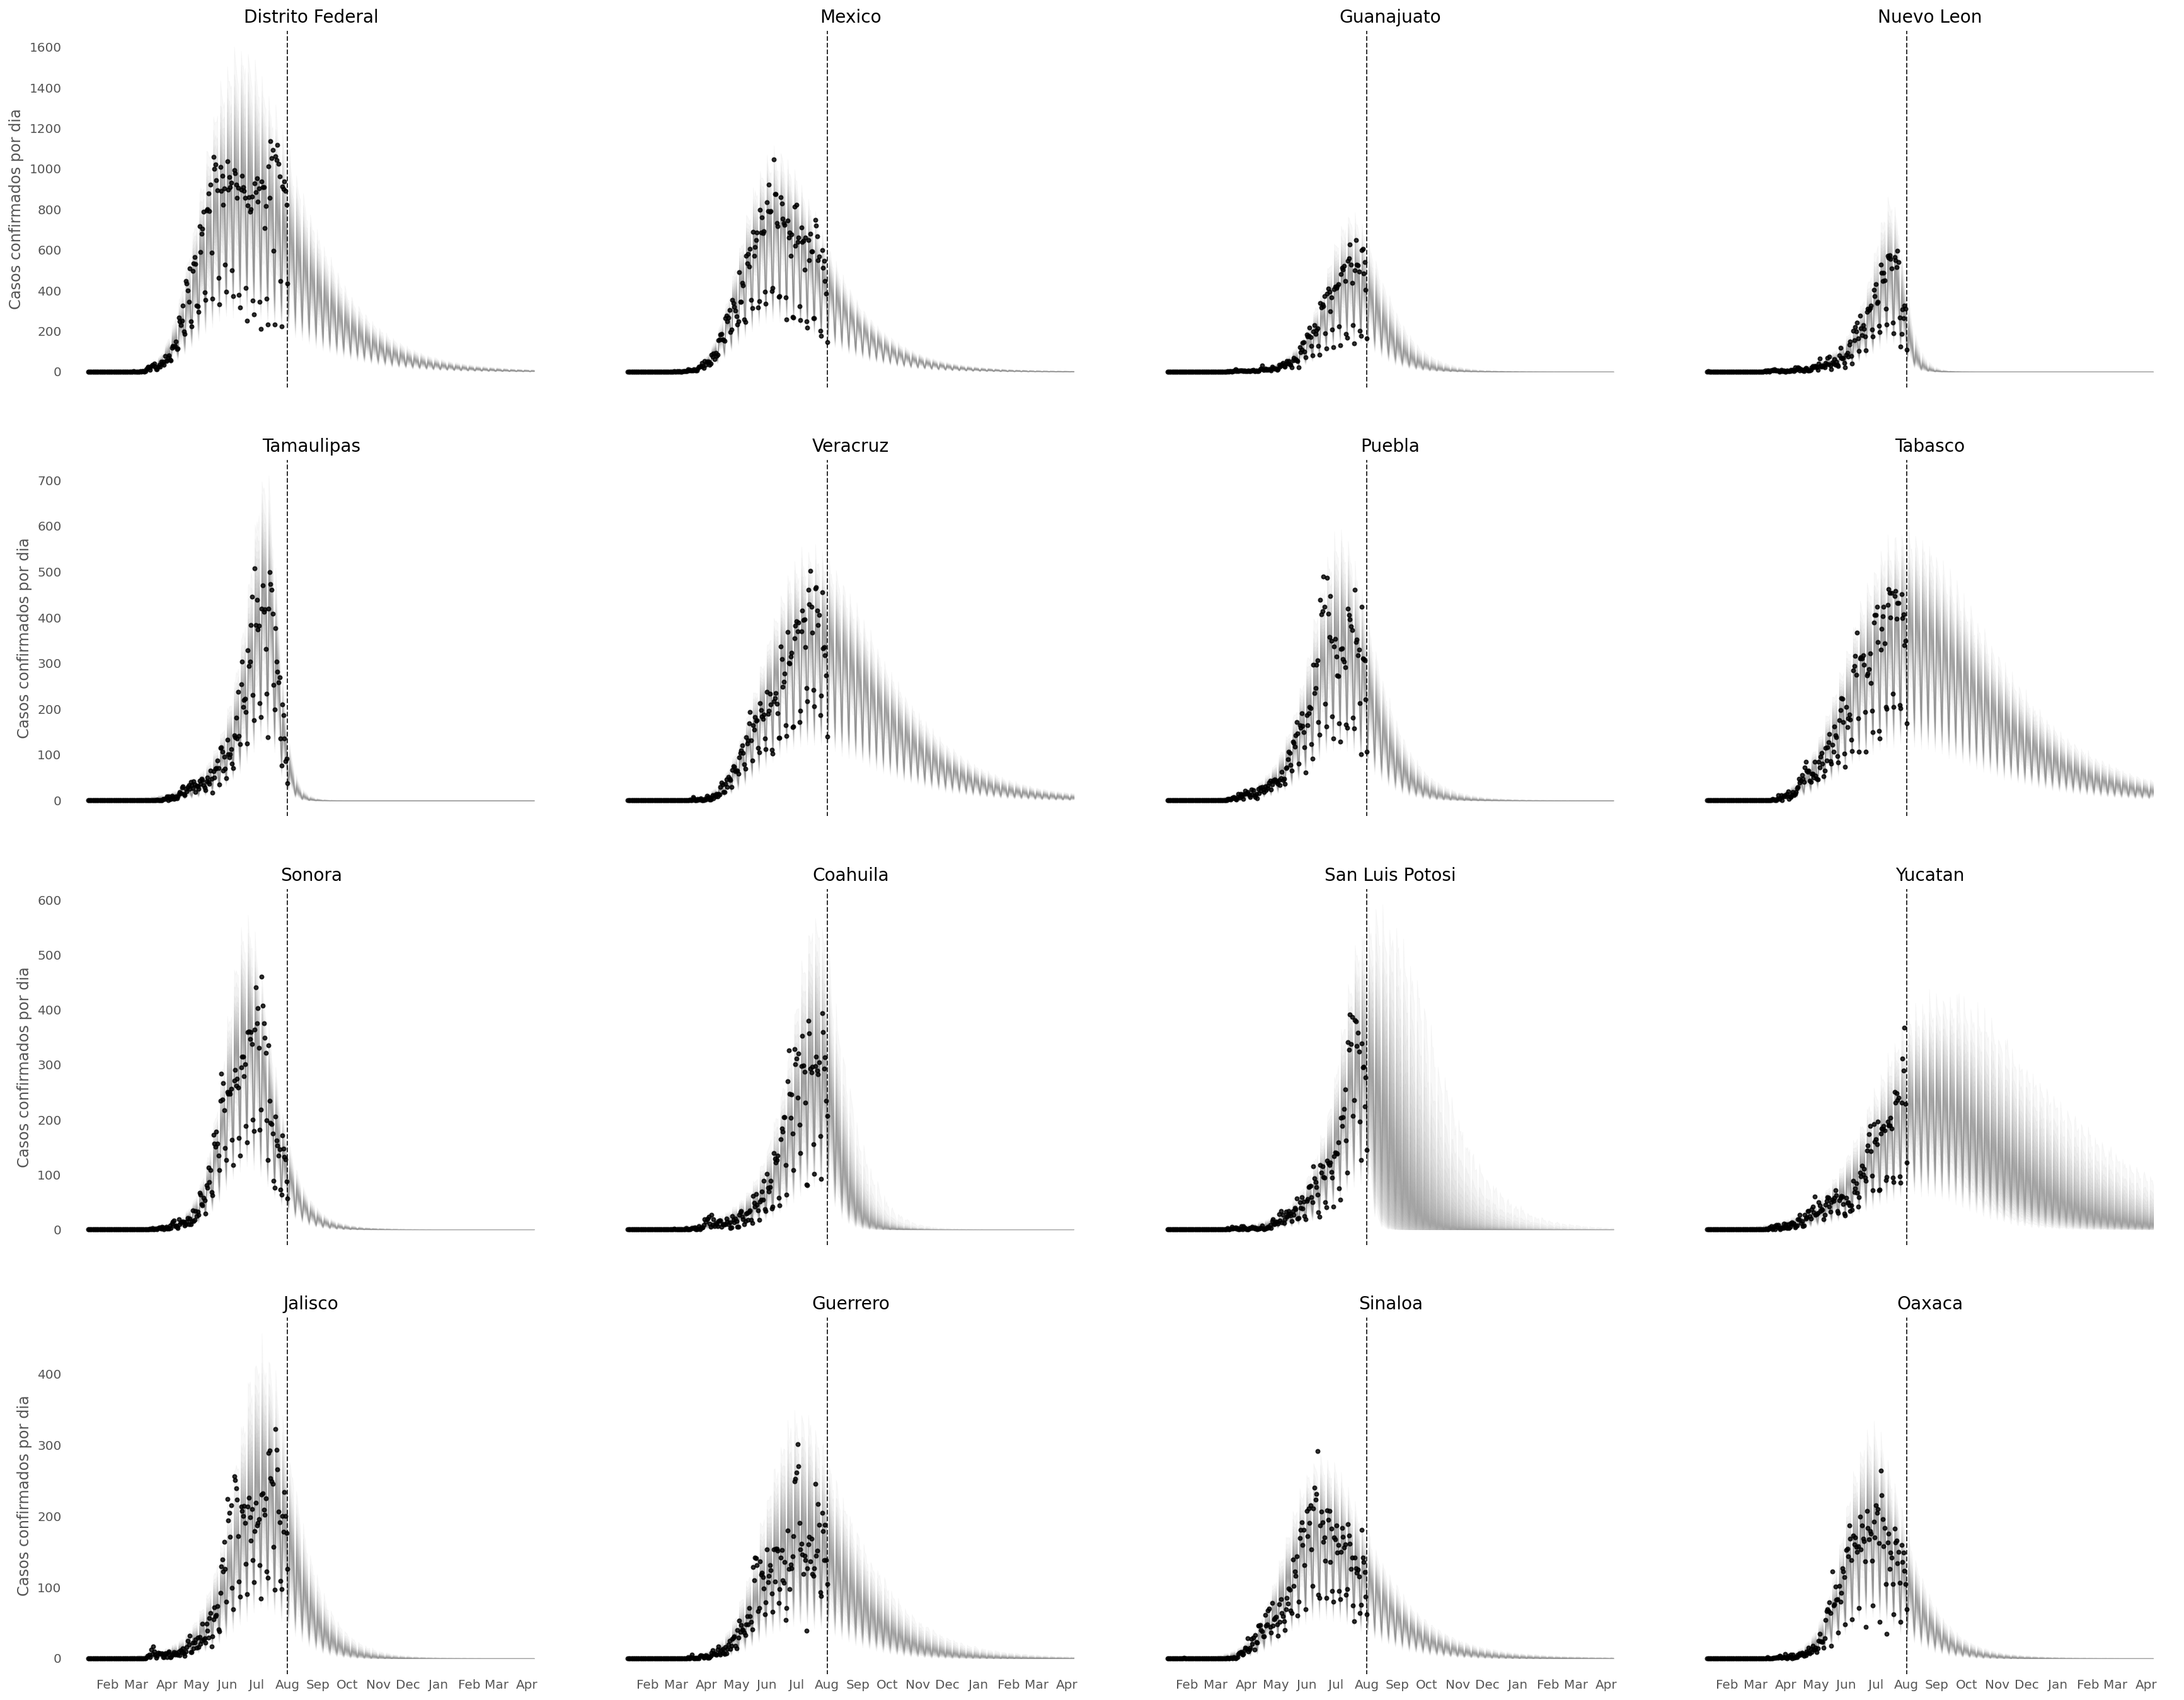

In [114]:
f, axes = plt.subplots(4, 4, figsize=(30, 4*6), sharey="row", sharex=True)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
for ax, state in zip(axes.flatten(), sorted_states[:16]):
    stan_index = coords["state"].index(state)
    state_samples = samples.extract()["y_pred"][..., stan_index]
    ax.axvline(x=coords['date'][-1], linestyle='--', color='black', linewidth=1, alpha=0.8)
    ax.plot(coords['date'], data['y'][:, stan_index], marker='.', color='black', linestyle='none', alpha=0.8, label='datos')
    tsplot(coords['forecast_date'], state_samples[:, :], ax=ax)
    ax.set_title(state.lower().title(), fontsize=14)
    ax.set_facecolor('white')
    ax.tick_params(length=0)
    ax.set_xticks(first_day_of_the_month)
    ax.set_xticklabels(labels)
#     ax.set_ylim([0, 200])
for ax in axes[:, 0].flatten():
    plt.sca(ax)
    plt.ylabel("Casos confirmados por dia")
    
plt.show()

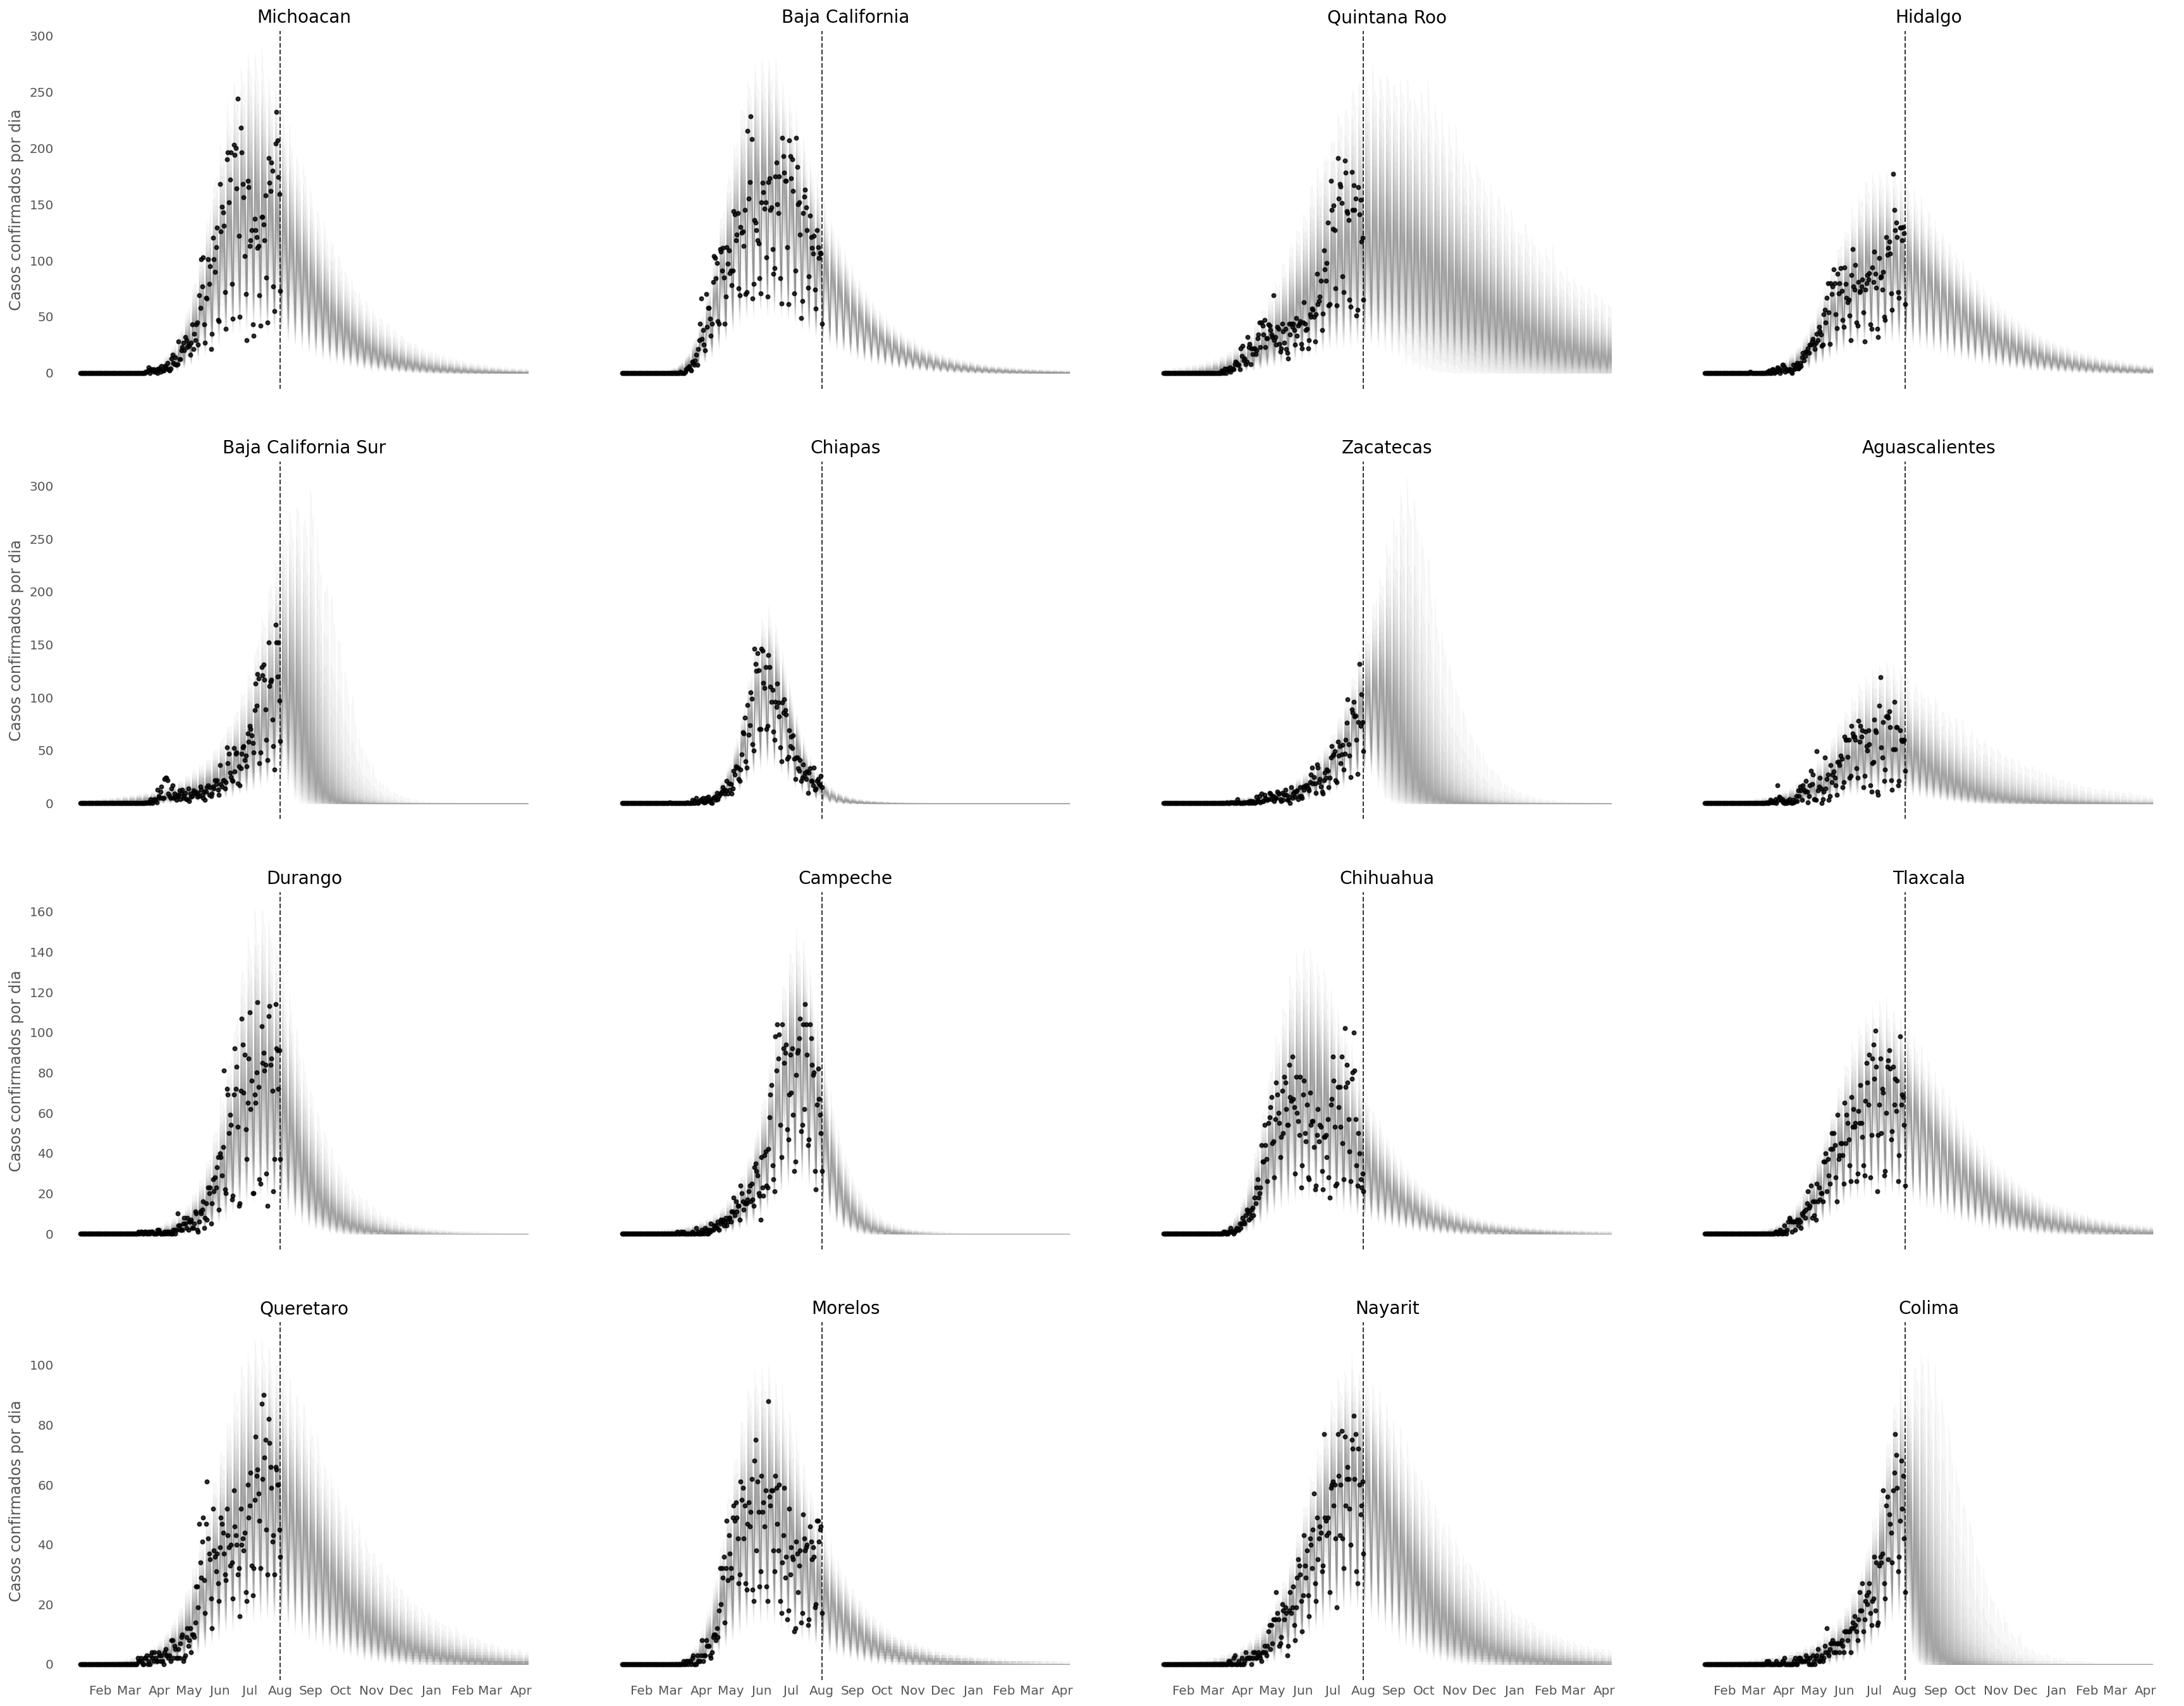

In [115]:
f, axes = plt.subplots(4, 4, figsize=(30, 4*6), sharey="row", sharex=True)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
for ax, state in zip(axes.flatten(), sorted_states[16:]):
    stan_index = coords["state"].index(state)
    state_samples = samples.extract()["y_pred"][..., stan_index]
    ax.axvline(x=coords['date'][-1], linestyle='--', color='black', linewidth=1, alpha=0.8)
    ax.plot(coords['date'], data['y'][:, stan_index], marker='.', color='black', linestyle='none', alpha=0.8, label='datos')
    tsplot(coords['forecast_date'], state_samples[:, :], ax=ax)
    ax.set_title(state.lower().title(), fontsize=14)
    ax.set_facecolor('white')
    ax.tick_params(length=0)
    ax.set_xticks(first_day_of_the_month)
    ax.set_xticklabels(labels)
#     ax.set_ylim([0, 200])
for ax in axes[:, 0].flatten():
    plt.sca(ax)
    plt.ylabel("Casos confirmados por dia")
    
plt.show()

In [116]:
median_final_count = np.quantile(np.sum(samples.extract()["y_pred"], axis=1), 0.50, axis=0)
lower_final_count = np.quantile(np.sum(samples.extract()["y_pred"], axis=1), 0.025, axis=0)
upper_final_count = np.quantile(np.sum(samples.extract()["y_pred"], axis=1), 0.975, axis=0)

order=median_final_count.argsort()

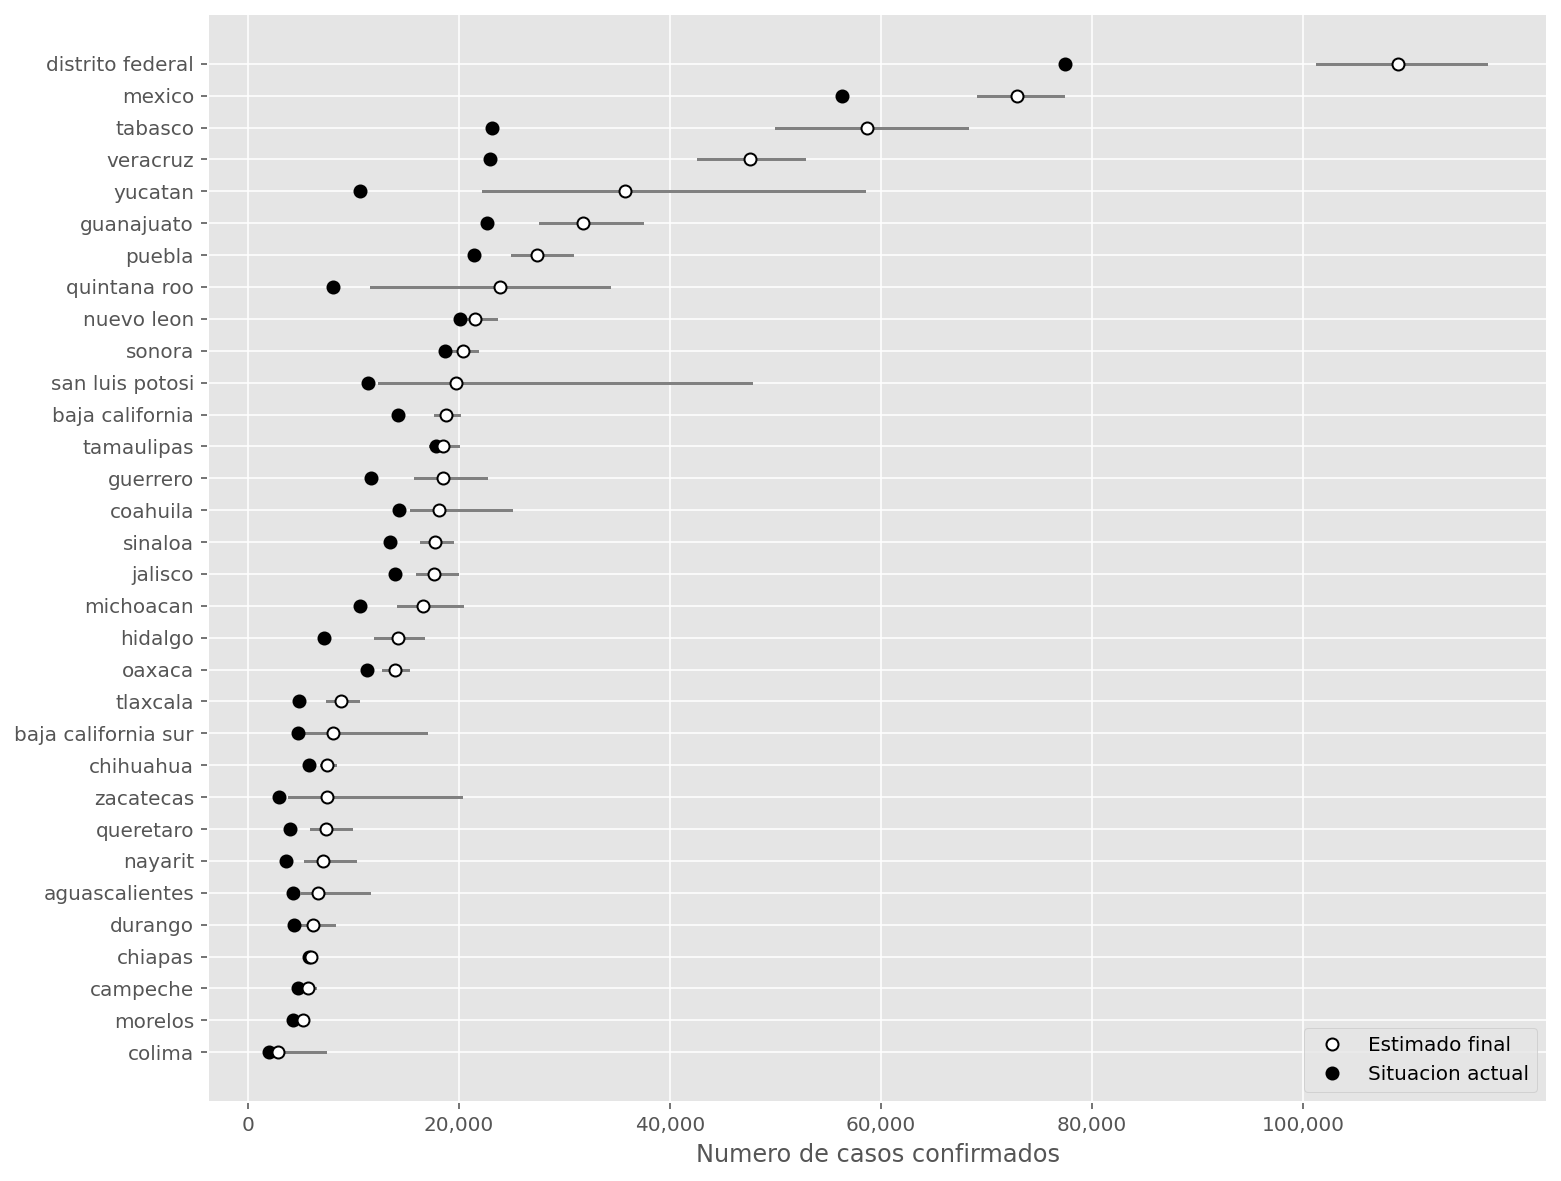

In [125]:
f = plt.figure(figsize=(12, 10))
plt.plot(median_final_count[order], range(len(median_final_count)), marker='o', linestyle='none', color='k', markerfacecolor='white', zorder=100, label='Estimado final')
for n, (x1, x2) in enumerate(zip(lower_final_count[order], upper_final_count[order])):
    plt.plot([x1, x2], [n, n], color='gray', markerfacecolor='none')

plt.plot(data['y'][:, order].sum(axis=0), range(len(order)), marker='o', color='black', linestyle='none', label='Situacion actual')
plt.yticks(range(len(order)), [coords["state"][i].lower() for i in order])
xticks = [0, 20_000, 40000, 60000, 80000, 100000]
plt.xticks(xticks, [format(n, ",") for n in xticks])
plt.xlabel("Numero de casos confirmados")
plt.legend(loc='lower right')
plt.show()

# Save the samples

In [167]:
idata = arviz.from_pystan(
    samples,
    observed_data=['y', 'pop'],
    predictions=['y_pred', 'y_trend',],
    dims={
        'y': ['date', 'state'],
        'y_pred': ['forecast_date', 'state'],
        'y_trend': ['forecast_date', 'state'],
        'pop': ['state'],
        'alpha': ['state'],
        'beta': ['state'],
        'nu': ['state'],
        'S': ['state'],
        'phi': ['state'],
        "mu_theta": ["growth_parameter"],
        "sigma_theta": ["growth_parameter"],
        "log_theta": ["state", "growth_parameter"],
        'dow': ['day'],
    },
    coords={
        **coords,
        **{
            'day': [d.day_name() for d in coords['date'][:6]],
            'growth_parameter': ["alpha", "beta", "nu", "S"],
        }
    },
)

In [168]:
idata

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data

In [198]:
idata.to_netcdf("./forecast_covid_mx.nc")

'./forecast_covid_mx.nc'

In [200]:
# Read in the saved samples
# arviz.InferenceData.from_netcdf('./forecast_covid_mx.nc')